In [1]:
import pandas as pd
import plotly.express as px
import seaborn as sns
from matplotlib import pyplot as plt
from exo_finder.default_datasets import exo_dataset

# Known Exoplanet dataset exploration

In [2]:
exo_db = exo_dataset.load_known_exoplanets_dataset(with_gaia_star_data=True).get_default_records()
exo_df = exo_db.to_pandas()
exo_df

,tic_id,pl_name,pl_letter,hostname,hd_name,hip_name,default_flag,pl_refname,st_refname,sy_refname,...,sy_kepmag_lower,st_rotp_upper,st_rotp_lower,pl_projobliq_upper,pl_projobliq_lower,pl_trueobliq_upper,pl_trueobliq_lower,sy_icmag_upper,sy_icmag_lower,st_rad_gaia
0,-1,KMT-2016-BLG-2605L b,b,KMT-2016-BLG-2605L,,,1,<a refstr=RYU_ET_AL__2021 href=https://ui.adsa...,<a refstr=RYU_ET_AL__2021 href=https://ui.adsa...,<a refstr=RYU_ET_AL__2021 href=https://ui.adsa...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,MOA-2010-BLG-073L b,b,MOA-2010-BLG-073L,,,1,<a refstr=STREET_ET_AL__2013 href=https://ui.a...,<a refstr=STREET_ET_AL__2013 href=https://ui.a...,<a refstr=STREET_ET_AL__2013 href=https://ui.a...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,KMT-2017-BLG-2509L b,b,KMT-2017-BLG-2509L,,,1,<a refstr=HAN_ET_AL__2021 href=https://ui.adsa...,<a refstr=HAN_ET_AL__2021 href=https://ui.adsa...,<a refstr=HAN_ET_AL__2021 href=https://ui.adsa...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-1,KMT-2021-BLG-2010L b,b,KMT-2021-BLG-2010L,,,1,<a refstr=HAN_ET_AL__2023 href=https://ui.adsa...,<a refstr=HAN_ET_AL__2023 href=https://ui.adsa...,<a refstr=HAN_ET_AL__2023 href=https://ui.adsa...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,268932150,Kepler-1079 b,b,Kepler-1079,,,1,<a refstr=MORTON_ET_AL__2016 href=https://ui.a...,<a refstr=MORTON_ET_AL__2016 href=https://ui.a...,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5962,68952448,WASP-67 b,b,WASP-67,,,1,<a refstr=STASSUN_ET_AL__2017 href=https://ui....,<a refstr=STASSUN_ET_AL__2017 href=https://ui....,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.904095
5963,442530946,WASP-70 A b,b,WASP-70 A,HD 358155,,1,<a refstr=ANDERSON_ET_AL__2014 href=https://ui...,<a refstr=ANDERSON_ET_AL__2014 href=https://ui...,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.243030
5964,248853232,WASP-69 b,b,WASP-69,,,1,<a refstr=STASSUN_ET_AL__2017 href=https://ui....,<a refstr=STASSUN_ET_AL__2017 href=https://ui....,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.872724
5965,364173220,HU Aqr AB c,c,HU Aqr,,,1,<a refstr=QIAN_ET_AL__2011 href=https://ui.ads...,<a refstr=QIAN_ET_AL__2011 href=https://ui.ads...,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Discoveries per telescope

In [3]:
# Discoveries by telescope
(exo_df
    .groupby("disc_facility")
    .aggregate({"disc_year": "min", "disc_facility": "count"})
    .rename(columns={"disc_facility": "total_discoveries", "disc_year": "year_of_first_discovery"})
    .sort_values(by="total_discoveries", ascending=False))

,year_of_first_discovery,total_discoveries
disc_facility,,
Kepler,2009,2784
Transiting Exoplanet Survey Satellite (TESS),2018,675
K2,2014,547
Multiple Observatories,1996,328
La Silla Observatory,1999,294
...,...,...
Kitt Peak National Observatory,2006,1
Leoncito Astronomical Complex,2012,1
Teide Observatory,2008,1


#### Cumulative discoveries over the years, and discovery methods

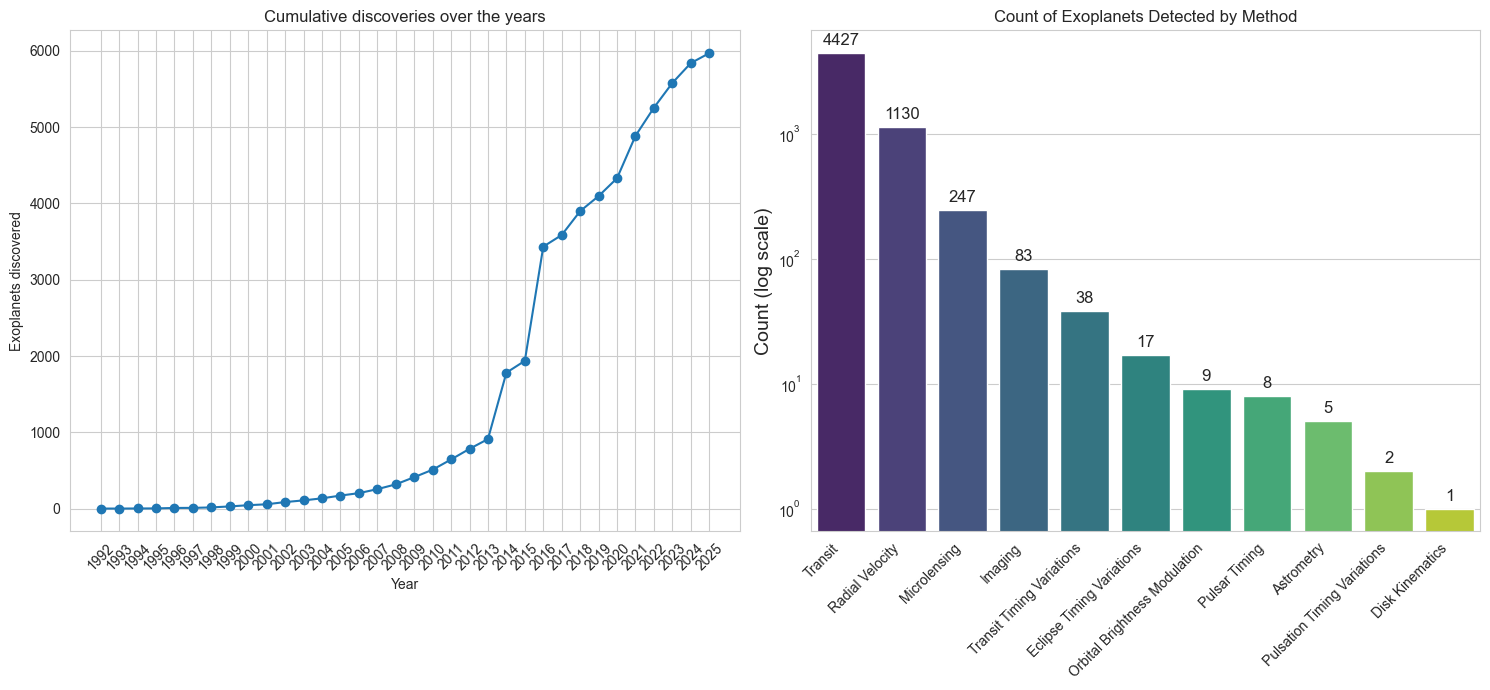

In [4]:
def discoveries_by_year() -> pd.DataFrame:
    sum_by_year = (exo_df
                   .groupby("disc_year")
                   .aggregate({"disc_year": "count"})
                   .rename(columns={"disc_year": "count"})
                   .sort_values(by="disc_year")
                   .cumsum().reset_index())
    missing = pd.DataFrame({"disc_year": 1993, "count": 2}, index=[0])
    sum_by_year = pd.concat([sum_by_year, missing], ignore_index=True).sort_values(by="disc_year")
    return sum_by_year

def plot_discoveries_by_year_and_type():
    disc_by_year = discoveries_by_year()
    count_per_type = exo_df.groupby("discoverymethod", observed=False).size().rename("count").reset_index().sort_values(by="count", ascending=False)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
    ax1.plot(disc_by_year["disc_year"], disc_by_year["count"], marker='o')
    ax1.set(title="Cumulative discoveries over the years", xlabel="Year", ylabel="Exoplanets discovered", xticks=disc_by_year['disc_year'].unique())
    ax1.xaxis.set_tick_params(rotation=45)
    
    # Create the bar plot
    # barplot = sns.barplot(x="discoverymethod", y="count", data=count_per_type, palette="viridis", ax=ax2)
    barplot = sns.barplot(x="discoverymethod", y="count", hue="discoverymethod", data=count_per_type, palette="viridis", legend=False, ax=ax2)
    
    # Set y-axis to logarithmic scale
    barplot.set_yscale('log')
    
    # Add the count labels on top of each bar
    for p in barplot.patches:
        barplot.annotate(format(p.get_height(), '.0f'),
                         (p.get_x() + p.get_width() / 2., p.get_height()),
                         ha='center', va='center', xytext=(0, 9),
                         textcoords='offset points', fontsize=12)
    
    # Set the labels and title
    barplot.set_xlabel('', fontsize=14)
    barplot.set_ylabel('Count (log scale)', fontsize=14)
    barplot.set_title('Count of Exoplanets Detected by Method')
    
    # Rotate x-axis labels for better readability
    plt.setp(barplot.get_xticklabels(), rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

plot_discoveries_by_year_and_type()

## Planets and Host Stars statistics

In [5]:
# How many planets per star
planets_per_star = exo_df.groupby("hostname").size()
px.histogram(planets_per_star, title="How many planets per star").show()

In [6]:
px.scatter(exo_df, x="st_mass", y="pl_rade", log_y=True, log_x=True, title="Star size vs planet radius").show()

In [7]:
px.scatter(exo_df, x="pl_orbper", y="pl_rade", log_y=True, log_x=True, title="Planet orbital period VS radius").show()

# Stars statistics

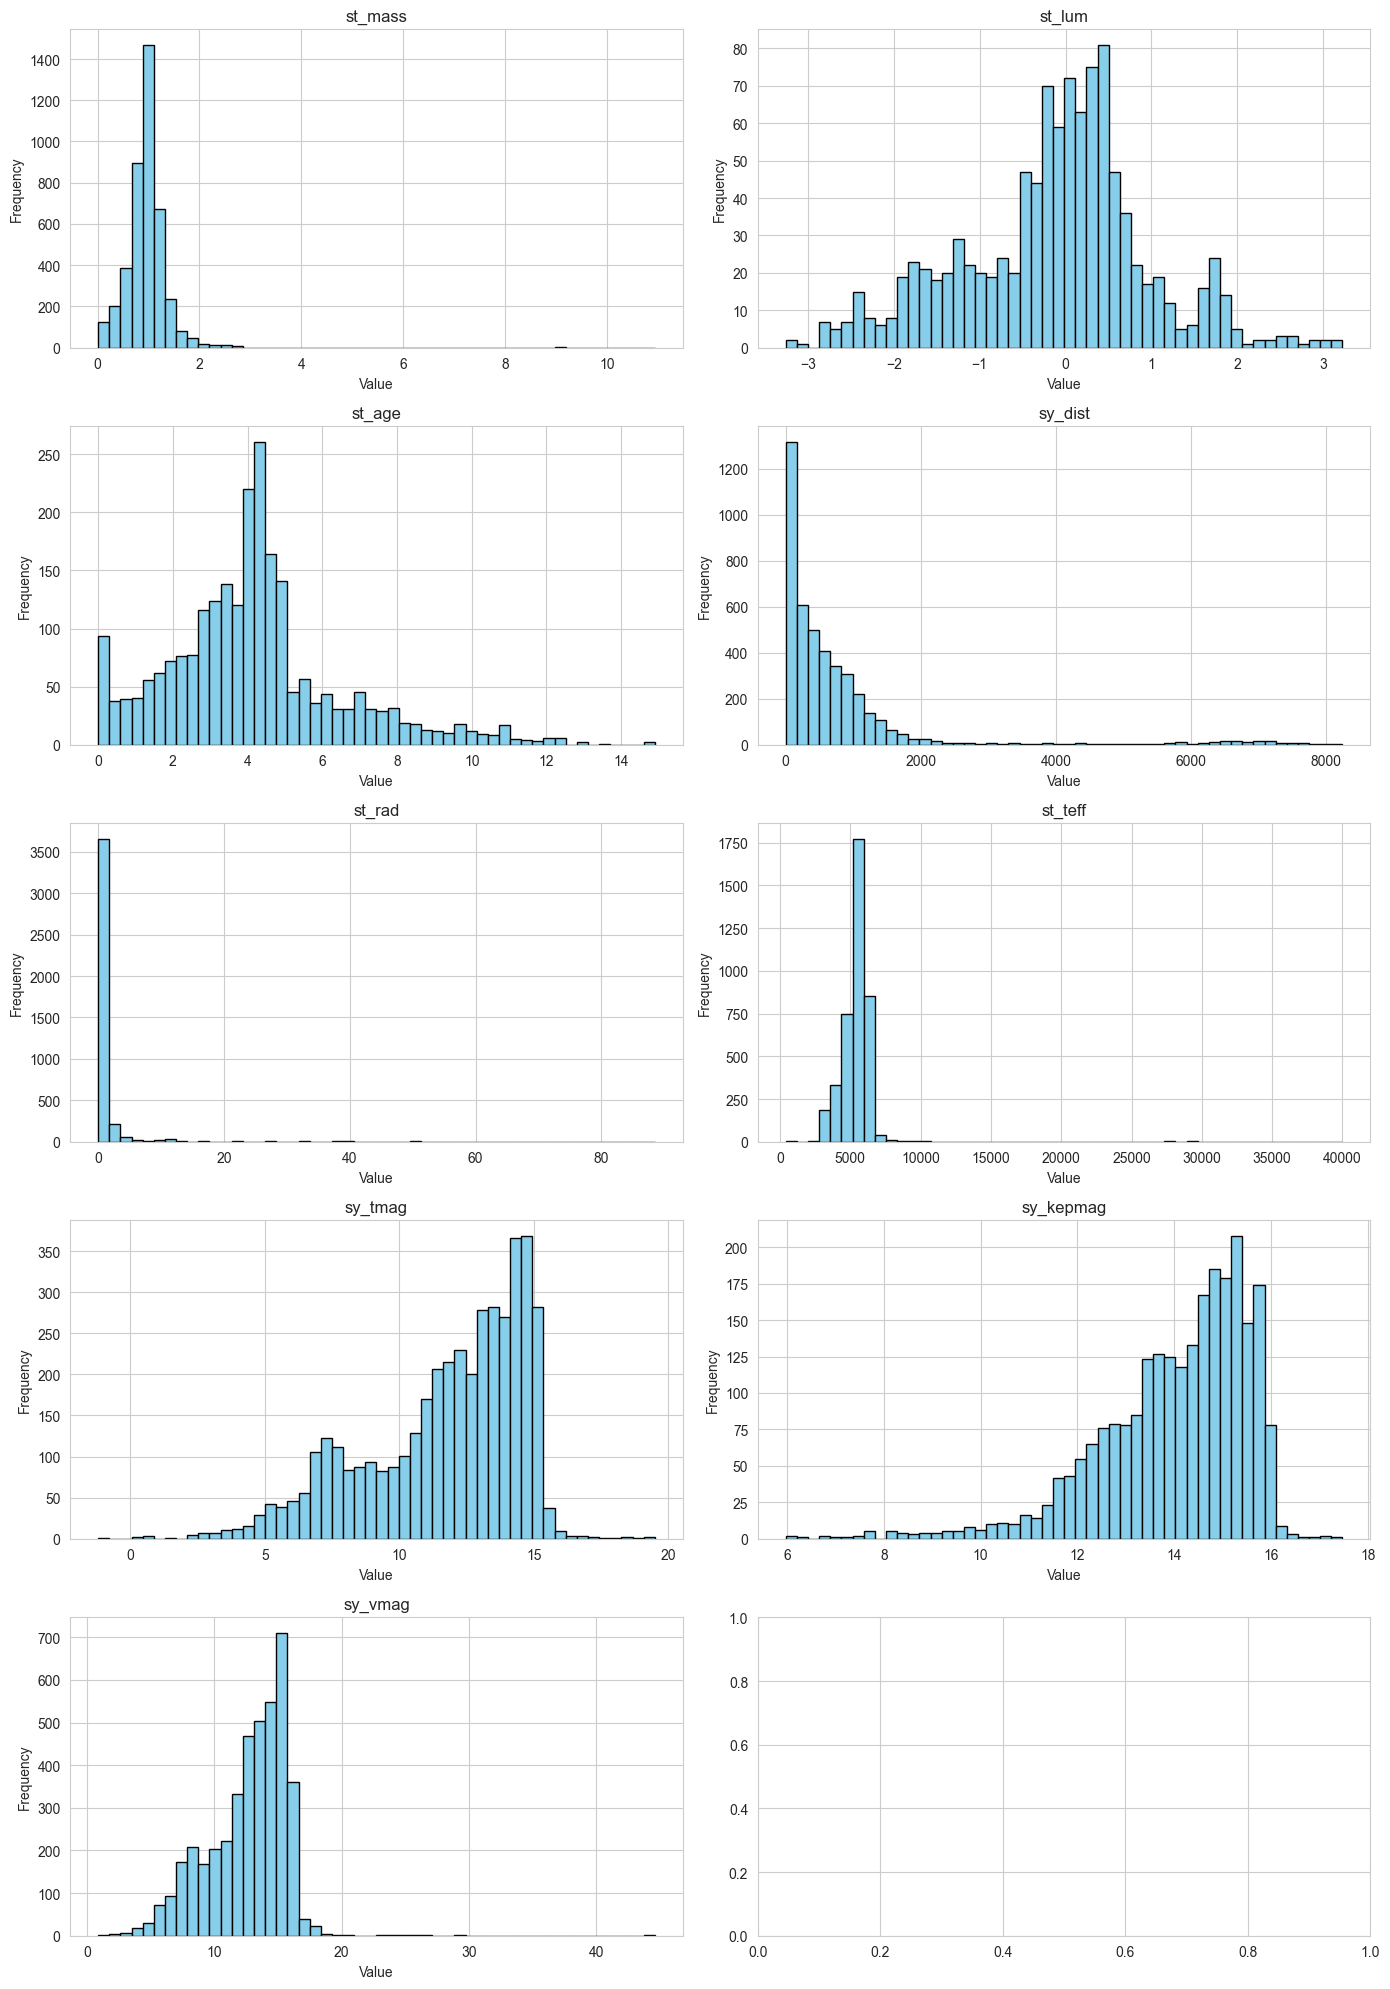

In [8]:
unique_stars = exo_df.groupby('hostname').agg({
    "st_mass": "mean",
    "st_lum": "mean",
    "st_age": "mean",
    "sy_dist": "mean",
    "st_rad": "mean",
    "st_teff": "mean",
    "sy_tmag": "mean",
    "sy_kepmag": "mean",
    "sy_vmag": "mean",
    "st_spectype": "first"  
})

# Plotting histograms for each column
cols = unique_stars.columns[:-1]
nrows = (1+len(cols)) // 2
fig, axes = plt.subplots(nrows=nrows, ncols=2, figsize=(14, nrows*4))
axes = axes.flatten()

# Loop through each column and plot histogram
for i, column in enumerate(cols):
    ax = axes[i]
    filtered_values = unique_stars[unique_stars[column] != 0][column]
    ax.hist(filtered_values, bins=50, color='skyblue', edgecolor='black')
    ax.set_title(column)
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()
plt.show()

# Planets statistics

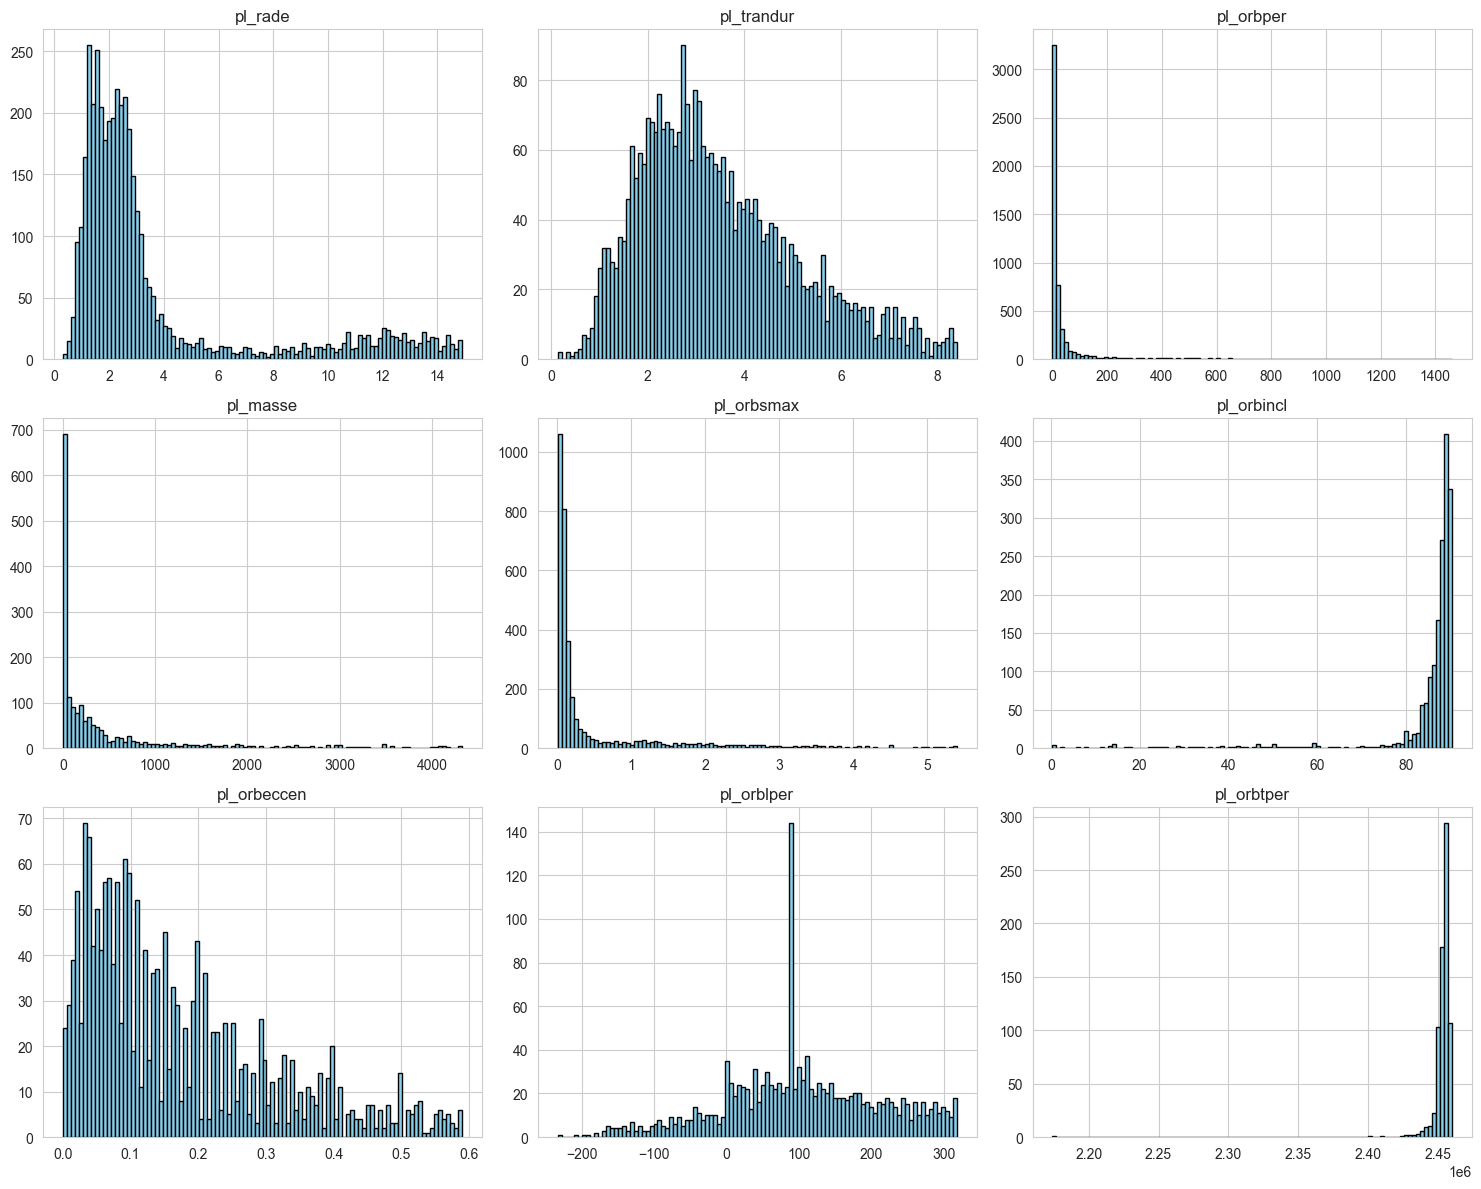

In [9]:
planet_parameters = ["pl_rade", "pl_trandur", "pl_orbper", "pl_masse", "pl_orbsmax", "pl_orbincl", "pl_orbeccen", "pl_orblper", "pl_orbtper"]
# Plotting histograms for each column
cols = planet_parameters
ncols = 3
nrows = (2+len(cols)) // ncols
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows*4))
axes = axes.flatten()

# Loop through each column and plot histogram
for i, column in enumerate(cols):
    ax = axes[i]
    filtered_values = exo_df[exo_df[column] != 0][column].dropna()
    filtered_values = filtered_values[filtered_values.abs() < filtered_values.quantile(q=0.95)]
    ax.hist(filtered_values, bins=100, color='skyblue', edgecolor='black')
    ax.set_title(column)

# Adjust layout
plt.tight_layout()
plt.show()

In [11]:
def study_transit_midpoints():
    """
    Studies the transit midpoints for systems with multiple planets
    """
    midpoints = (
        exo_df[["pl_tranmid", "disc_year", "hostname"]]
        .dropna()
        .groupby("hostname")
        .agg(
            count=("pl_tranmid", "count"),
            pl_tranmid_min=("pl_tranmid", "min"),
            pl_tranmid_max=("pl_tranmid", "max"),
            diff_pl_tranmid=("pl_tranmid", lambda x: x.max() - x.min()),
            disc_year=("disc_year", "first"))
         .sort_values(by="disc_year", ascending=False))
    
    midpoints = midpoints[midpoints["diff_pl_tranmid"].values.astype(float) > 0]
    #fit_data(midpoints["diff_pl_tranmid"], plot=True, upper_limit=500, include_zeros=False)
    return midpoints

study_transit_midpoints()

,count,pl_tranmid_min,pl_tranmid_max,diff_pl_tranmid,disc_year
hostname,,,,,
G 192-15,2,2017-04-08 07:40:47.999985516,2019-11-25 12:00:00.000000000,961 days 04:19:12.000014484,2025
TIC 434398831,2,2018-12-16 03:14:23.999980688,2018-12-18 02:58:24.960000515,1 days 23:44:00.960019827,2025
TOI-1803,2,2020-02-25 02:58:07.679989636,2020-03-03 04:11:34.079987705,7 days 01:13:26.399998069,2025
HD 35843,2,2021-01-07 06:08:55.680015385,2022-11-06 04:35:02.400009334,667 days 22:26:06.719993949,2025
Kepler-289,4,2009-05-14 04:30:34.559981525,2009-12-08 11:41:16.800017059,208 days 07:10:42.240035534,2025
...,...,...,...,...,...
Kepler-25,3,2011-05-21 22:04:51.456019878,2011-06-02 12:00:00.000000000,11 days 13:55:08.543980122,2011
Kepler-20,5,2009-05-16 00:03:14.399991632,2009-06-15 05:30:37.440016866,30 days 05:27:23.040025234,2011
Kepler-18,3,2009-05-15 00:09:47.520007789,2009-12-03 16:15:44.640004635,202 days 16:05:57.119996846,2011
